In [ ]:
import pandas as pd
import numpy as np
import duckdb as duck
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import optuna
import pickle

In [9]:
SEED:int = 10
SHUFFLE = True
LOCAL = True  # Using To Read Paths if running on Kaggle
DEVICE = "cuda"
model_name = "xgboost_02.pkl"

In [8]:
def dtype_down_allocating(df: pd.DataFrame) -> pd.DataFrame:
    ini_mb_usage = df.memory_usage().sum() / 1024**2

    f16min, f16max = np.finfo(np.float16).min, np.finfo(np.float16).max
    f32min, f32max = np.finfo(np.float32).min, np.finfo(np.float32).max

    i16min, i16max = np.iinfo(np.int16).min, np.iinfo(np.int16).max
    i32min, i32max = np.iinfo(np.int32).min, np.iinfo(np.int32).max

    for col in df.columns:
        col_dtype = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_dtype):
            col_max = df[col].max()
            col_min = df[col].min()

            if pd.api.types.is_float_dtype(col_dtype):
                if col_min >= f16min and col_max <= f16max:
                    df[col] = df[col].astype(np.float16)
                elif col_min >= f32min and col_max <= f32max:
                    df[col] = df[col].astype(np.float32)

            elif pd.api.types.is_integer_dtype(col_dtype):
                if col_min >= i16min and col_max <= i16max:
                    df[col] = df[col].astype(np.int16)
                elif col_min >= i32min and col_max <= i32max:
                    df[col] = df[col].astype(np.int32)
                
    end_mb_usage = (df.memory_usage().sum() / 1024**2) *100
    
    print(f'{np.round((end_mb_usage-ini_mb_usage)/ini_mb_usage, 2)}%')
        
    return df

In [ ]:
if LOCAL:
    train_df = dtype_down_allocating(pd.read_csv(r"../../data/CMI_Sensor_Data/train.csv"))
    test_df = dtype_down_allocating(pd.read_csv(r"../../data/CMI_Sensor_Data/test.csv"))
    train_demo = pd.read_csv(r"../../data/CMI_Sensor_Data/train_demographics.csv")
    test_demo = pd.read_csv(r"../../data/CMI_Sensor_Data/test_demographics.csv")
else:
    train_df = dtype_down_allocating(pd.read_csv(r"/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv"))
    test_df = dtype_down_allocating(pd.read_csv(r"/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv"))
    train_demo = pd.read_csv(r"/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")
    test_demo = pd.read_csv(r"/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv")

25.76%
24.7%


In [5]:
excluded_cols = ['gesture', 'sequence_type', 'behavior', 'orientation','phase'  # Only in Train
    ,'sequence_id', 'sequence_counter',  # Ids
    'row_id', 'subject', 'phase']  # metadata]

X = train_df.merge(right=train_demo,how='left',on=['subject']).drop(columns=excluded_cols)
y = train_df['gesture']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=SHUFFLE)

le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test= le.transform(y_test)

In [7]:
train_df.select_dtypes(include='object').columns

Index(['row_id', 'sequence_type', 'sequence_id', 'subject', 'orientation',
       'behavior', 'phase', 'gesture'],
      dtype='object')

In [10]:
model = xgb.XGBClassifier(
        max_depth= 7,
        learning_rate= 0.1,
        n_estimators= 70,
        subsample= 0.37467576245415724,
        colsample_bytree= 0.35716664430148
        ,eval_metric='mlogloss'
        ,verbosity=1
        ,device="cuda"
        ,early_stopping_rounds=3)

model.fit(X_train ,y_train ,eval_set=[(X_test,y_test)] ,verbose=True)

[0]	validation_0-mlogloss:2.72065
[1]	validation_0-mlogloss:2.59175
[2]	validation_0-mlogloss:2.48828
[3]	validation_0-mlogloss:2.40250
[4]	validation_0-mlogloss:2.32589
[5]	validation_0-mlogloss:2.25594
[6]	validation_0-mlogloss:2.19446
[7]	validation_0-mlogloss:2.13943
[8]	validation_0-mlogloss:2.08876
[9]	validation_0-mlogloss:2.04263
[10]	validation_0-mlogloss:2.00035
[11]	validation_0-mlogloss:1.96111
[12]	validation_0-mlogloss:1.92302
[13]	validation_0-mlogloss:1.88851
[14]	validation_0-mlogloss:1.85633
[15]	validation_0-mlogloss:1.82587
[16]	validation_0-mlogloss:1.79800
[17]	validation_0-mlogloss:1.77188
[18]	validation_0-mlogloss:1.74759
[19]	validation_0-mlogloss:1.72413
[20]	validation_0-mlogloss:1.70236
[21]	validation_0-mlogloss:1.68141
[22]	validation_0-mlogloss:1.66077
[23]	validation_0-mlogloss:1.64097
[24]	validation_0-mlogloss:1.62330
[25]	validation_0-mlogloss:1.60584
[26]	validation_0-mlogloss:1.58866
[27]	validation_0-mlogloss:1.57267
[28]	validation_0-mlogloss:1.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.35716664430148, device='cuda',
              early_stopping_rounds=3, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=70, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
pd.merge(y_train, X_train['target'], left_index=True, right_index=True)

In [ ]:
y_pred = model.predict(X_test)

#f1_score(y_test,y_test, average='macro')

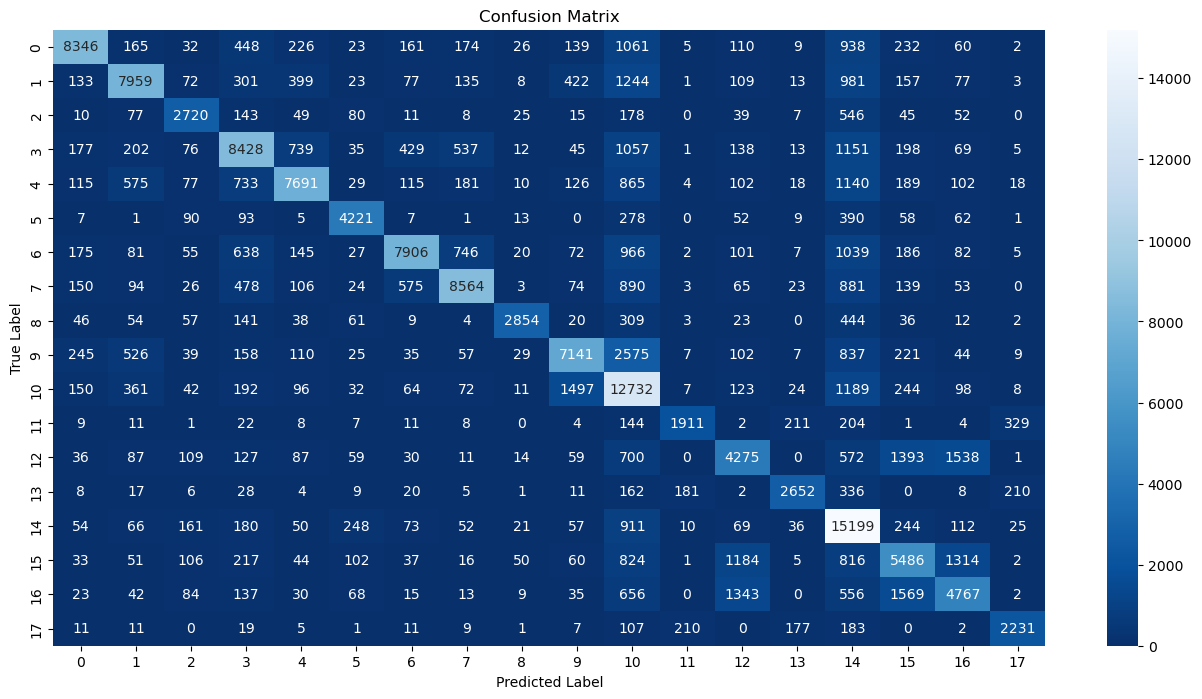

In [29]:
plt.figure(figsize=(16, 8))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues_r")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Kaggle Gateway inference

In [ ]:
if LOCAL == False:
    X_sub = test_df.copy() 
    X_sub = X_sub.merge(right=test_demo,how='left',on=['subject'])
    for col in X_train.columns:
        if col not in X_sub.columns:
            X_sub[col] = 0

    X_sub = X_sub[X_train.columns]

    sub_pred = model.predict(X_sub)
    sub_pred = le.inverse_transform(sub_pred)

    submission = pd.DataFrame({"sequence_id":test_df['sequence_id'],"gesture":sub_pred })


    submission.to_parquet('submission.parquet')
    """
    actual = pd.DataFrame({'gesture': le.inverse_transform(y_test)})
    pred = pd.DataFrame({'gesture': le.inverse_transform(y_pred)})
    
    metric = CompetitionMetric()
    score = metric.calculate_hierarchical_f1(actual, pred)
    print(f"Estimated leaderboard (val) score: {score:.4f}")"""


def predict(sequence: pl.DataFrame, demographics: pl.DataFrame) -> str:
    seq = sequence.to_pandas()
    demo = demographics.to_pandas()
    X = seq.merge(right=demo,how='left',on=['subject'])
    X = X[X_train.columns]

    
    model = joblib.load(r"/kaggle/input/cmi-xgboost-classifier-0.1-model/other/default/1/xgb_01.model")

    pred = model.predict(X)
    prediction = le.inverse_transform(pred)
    return str(prediction[0])